## Imports and Load + Split Data

In [1]:
from __future__ import print_function
import argparse
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
import os

train_dataset = datasets.MNIST('../data', train=True, download=True,
            transform=transforms.Compose([      
                transforms.ToTensor(),           
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

test_dataset = datasets.MNIST('../data', train=False,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

subset_indices_train = np.load('indices_train.npy')
subset_indices_valid = np.load('indices_valid.npy')

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64,
    sampler=SubsetRandomSampler(subset_indices_train)
)
val_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64,
    sampler=SubsetRandomSampler(subset_indices_valid)
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True)

## Best MNIST Classifier

In [2]:
class Net(nn.Module):
    '''
    Build the best MNIST classifier.
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), stride=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.norm = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.15)
        self.dropout2 = nn.Dropout2d(0.15)
        self.fc1 = nn.Linear(1600, 64)
        self.fc2 = nn.Linear(64, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output
    
def train(model, train_loader, optimizer, epoch):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()   # Set the model to training mode
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = F.nll_loss(output, target)   # Compute loss
        losses.append(loss.item())
        loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.sampler),
                100. * batch_idx / len(train_loader), loss.item()))     
    return np.average(losses)


def test(model, test_loader):
    model.eval()  
    test_loss = 0
    correct = 0
    test_num = 0
    with torch.no_grad():  
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_num += len(data)

    test_loss /= test_num
    print('\nAccuracy: {}/{} ({:.0f}%)\n'.format( correct, test_num, 100. * correct / test_num))
    return test_loss
    
model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

train_loss = []
test_loss = []
epochs = 5
for epoch in range(1, epochs + 1):
    train_loss.append(train(model, train_loader, optimizer, epoch))
    test_loss.append(test(model, val_loader))
    scheduler.step()  

print("Validation Set:")
test(model, val_loader)
print("Training Set:")
test(model, train_loader)

torch.save(model.state_dict(), "best_MNIST_Net.pt")

Train Epoch: 1 [0/51005 (0%)]	Loss: 2.298765
Train Epoch: 1 [640/51005 (1%)]	Loss: 1.698771
Train Epoch: 1 [1280/51005 (3%)]	Loss: 0.975032
Train Epoch: 1 [1920/51005 (4%)]	Loss: 0.512319
Train Epoch: 1 [2560/51005 (5%)]	Loss: 0.429376
Train Epoch: 1 [3200/51005 (6%)]	Loss: 0.303850
Train Epoch: 1 [3840/51005 (8%)]	Loss: 0.270514
Train Epoch: 1 [4480/51005 (9%)]	Loss: 0.338612
Train Epoch: 1 [5120/51005 (10%)]	Loss: 0.162839
Train Epoch: 1 [5760/51005 (11%)]	Loss: 0.373214
Train Epoch: 1 [6400/51005 (13%)]	Loss: 0.100432
Train Epoch: 1 [7040/51005 (14%)]	Loss: 0.322535
Train Epoch: 1 [7680/51005 (15%)]	Loss: 0.178247
Train Epoch: 1 [8320/51005 (16%)]	Loss: 0.274816
Train Epoch: 1 [8960/51005 (18%)]	Loss: 0.075819
Train Epoch: 1 [9600/51005 (19%)]	Loss: 0.153692
Train Epoch: 1 [10240/51005 (20%)]	Loss: 0.063248
Train Epoch: 1 [10880/51005 (21%)]	Loss: 0.105545
Train Epoch: 1 [11520/51005 (23%)]	Loss: 0.063896
Train Epoch: 1 [12160/51005 (24%)]	Loss: 0.141311
Train Epoch: 1 [12800/51005 

Train Epoch: 3 [3200/51005 (6%)]	Loss: 0.035755
Train Epoch: 3 [3840/51005 (8%)]	Loss: 0.052033
Train Epoch: 3 [4480/51005 (9%)]	Loss: 0.090283
Train Epoch: 3 [5120/51005 (10%)]	Loss: 0.083018
Train Epoch: 3 [5760/51005 (11%)]	Loss: 0.026878
Train Epoch: 3 [6400/51005 (13%)]	Loss: 0.005238
Train Epoch: 3 [7040/51005 (14%)]	Loss: 0.014349
Train Epoch: 3 [7680/51005 (15%)]	Loss: 0.016908
Train Epoch: 3 [8320/51005 (16%)]	Loss: 0.079983
Train Epoch: 3 [8960/51005 (18%)]	Loss: 0.050287
Train Epoch: 3 [9600/51005 (19%)]	Loss: 0.036127
Train Epoch: 3 [10240/51005 (20%)]	Loss: 0.022092
Train Epoch: 3 [10880/51005 (21%)]	Loss: 0.030949
Train Epoch: 3 [11520/51005 (23%)]	Loss: 0.003872
Train Epoch: 3 [12160/51005 (24%)]	Loss: 0.004607
Train Epoch: 3 [12800/51005 (25%)]	Loss: 0.019647
Train Epoch: 3 [13440/51005 (26%)]	Loss: 0.046447
Train Epoch: 3 [14080/51005 (28%)]	Loss: 0.013006
Train Epoch: 3 [14720/51005 (29%)]	Loss: 0.050461
Train Epoch: 3 [15360/51005 (30%)]	Loss: 0.073303
Train Epoch: 3

Train Epoch: 5 [5760/51005 (11%)]	Loss: 0.012011
Train Epoch: 5 [6400/51005 (13%)]	Loss: 0.001489
Train Epoch: 5 [7040/51005 (14%)]	Loss: 0.004301
Train Epoch: 5 [7680/51005 (15%)]	Loss: 0.050101
Train Epoch: 5 [8320/51005 (16%)]	Loss: 0.000896
Train Epoch: 5 [8960/51005 (18%)]	Loss: 0.027582
Train Epoch: 5 [9600/51005 (19%)]	Loss: 0.002556
Train Epoch: 5 [10240/51005 (20%)]	Loss: 0.001110
Train Epoch: 5 [10880/51005 (21%)]	Loss: 0.001542
Train Epoch: 5 [11520/51005 (23%)]	Loss: 0.004860
Train Epoch: 5 [12160/51005 (24%)]	Loss: 0.009576
Train Epoch: 5 [12800/51005 (25%)]	Loss: 0.019453
Train Epoch: 5 [13440/51005 (26%)]	Loss: 0.002079
Train Epoch: 5 [14080/51005 (28%)]	Loss: 0.000855
Train Epoch: 5 [14720/51005 (29%)]	Loss: 0.000802
Train Epoch: 5 [15360/51005 (30%)]	Loss: 0.069402
Train Epoch: 5 [16000/51005 (31%)]	Loss: 0.002630
Train Epoch: 5 [16640/51005 (33%)]	Loss: 0.070732
Train Epoch: 5 [17280/51005 (34%)]	Loss: 0.043735
Train Epoch: 5 [17920/51005 (35%)]	Loss: 0.020512
Train E

## Training and Validation Loss as a Function of Epoch

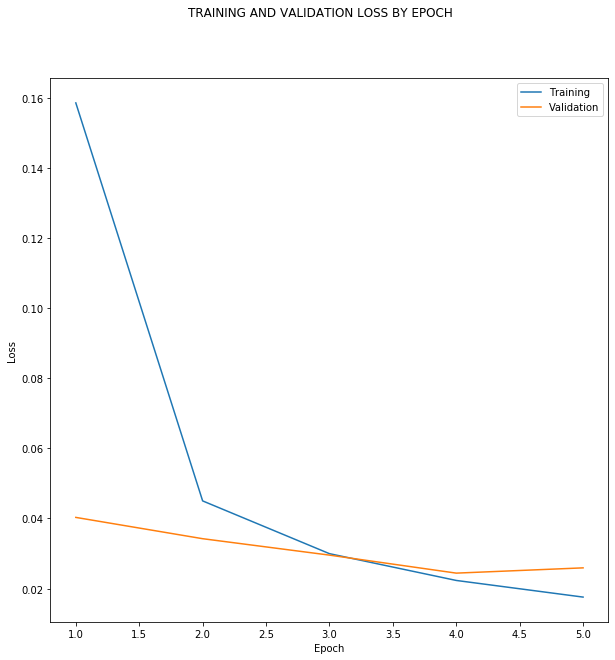

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(10, 10))
plt.plot(range(1, epochs+1), train_loss, label="Training")
plt.plot(range(1, epochs+1), test_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
fig.suptitle("TRAINING AND VALIDATION LOSS BY EPOCH")
plt.legend()
plt.savefig("train_and_valid_loss_by_epoch.png")